In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [ ]:
files = zf.ZipFile("dataset-resized.zip",'r')
 
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

In [ ]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, I'm going to create a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

Again, this is just housekeeping to organize my files.

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [3]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/home/horizon/Downloads/XDM_DOWNLOADS/data')

In [4]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

/usr/local/anaconda/lib/python3.7/site-packages/fastai/data_block.py:454: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [5]:
data

ImageDataBunch;

Train: LabelList (1616 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /home/horizon/Downloads/XDM_DOWNLOADS/data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/horizon/Downloads/XDM_DOWNLOADS/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/horizon/Downloads/XDM_DOWNLOADS/data

In [6]:
print(data.classes)

['glass', 'metal', 'paper', 'plastic']


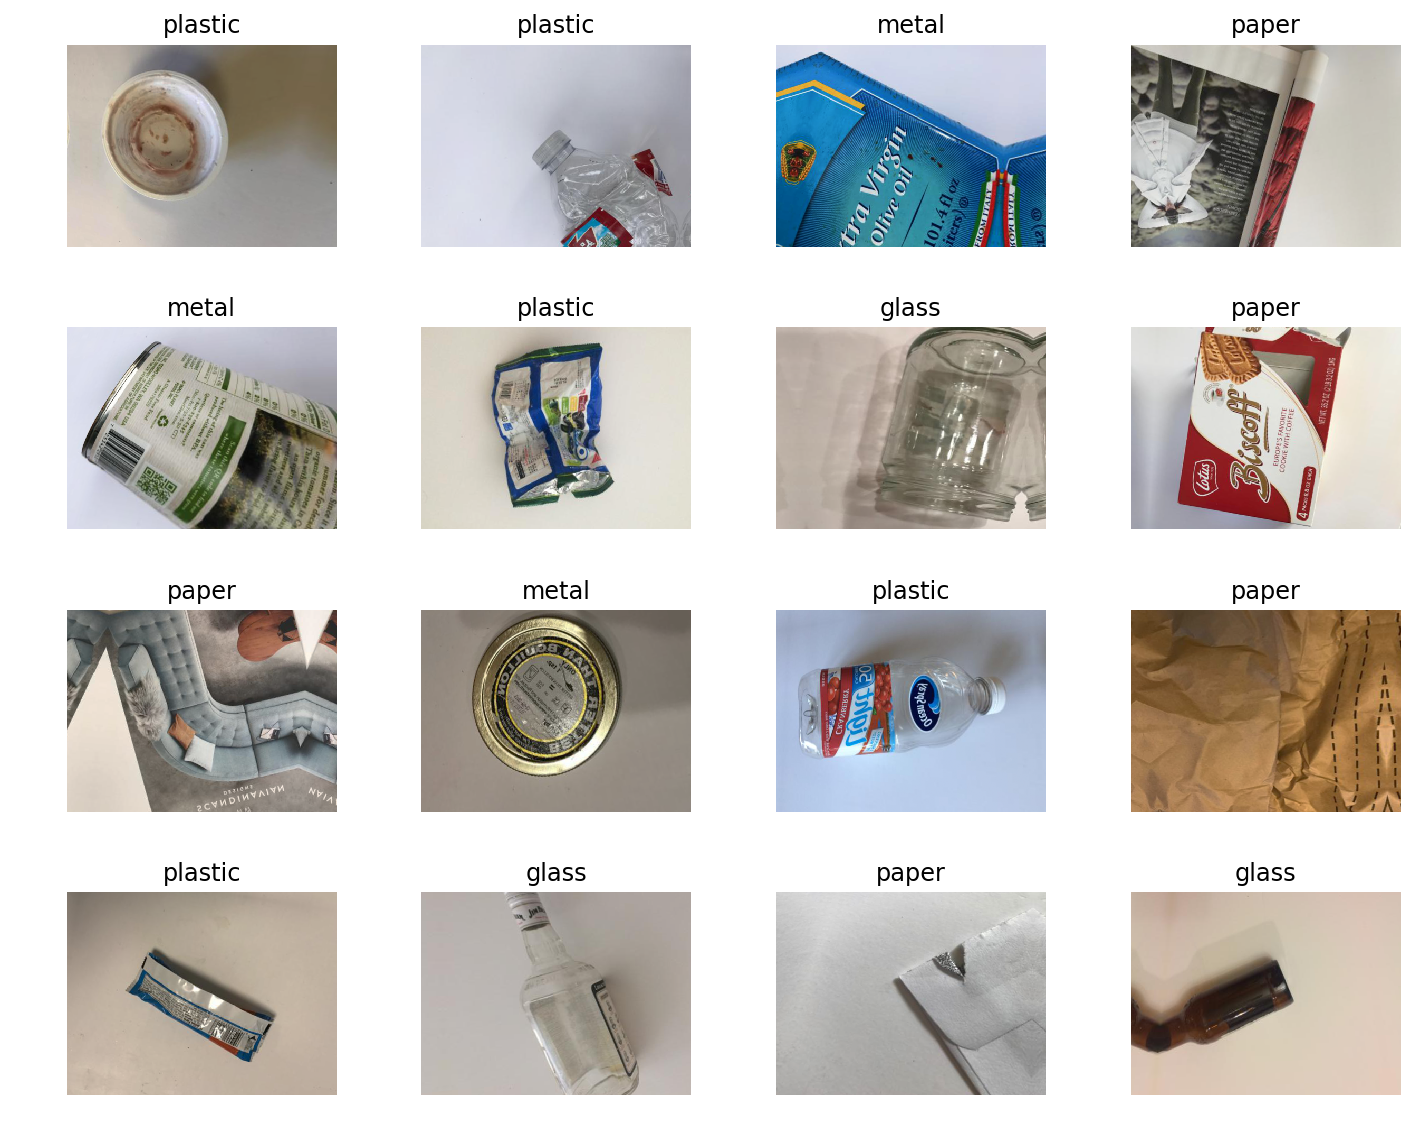

In [7]:
data.show_batch(rows=4,figsize=(10,8))

In [8]:
torch.cuda.is_available()

False

In [9]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/anaconda/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

In [ ]:
learn.save("trained_model", return_path=True)

In [15]:
learn=learn.load("trained_model")

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

IndexError: Traceback (most recent call last):
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/anaconda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/anaconda/lib/python3.7/site-packages/fastai/data_block.py", line 647, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/usr/local/anaconda/lib/python3.7/site-packages/fastai/data_block.py", line 118, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/usr/local/anaconda/lib/python3.7/site-packages/fastai/vision/data.py", line 270, in get
    fn = super().get(i)
  File "/usr/local/anaconda/lib/python3.7/site-packages/fastai/data_block.py", line 74, in get
    return self.items[i]
IndexError: index 0 is out of bounds for axis 0 with size 0


In [13]:
interp.plot_top_losses(9, figsize=(15,11))

NameError: name 'interp' is not defined

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [17]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [18]:
print(preds[0].shape)
preds[0]

torch.Size([635, 4])


tensor([[7.4705e-05, 9.7054e-01, 1.5822e-02, 1.3567e-02],
        [8.2297e-05, 2.0686e-04, 9.9965e-01, 6.5565e-05],
        [2.7223e-06, 2.0177e-04, 9.9421e-01, 5.5865e-03],
        ...,
        [1.0467e-04, 8.7161e-02, 8.7151e-01, 4.1220e-02],
        [9.8787e-01, 1.4043e-04, 1.5741e-05, 1.1971e-02],
        [1.2457e-03, 9.9767e-01, 1.4962e-04, 9.3963e-04]])

In [19]:
data.classes

['glass', 'metal', 'paper', 'plastic']

In [20]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [21]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [22]:
yhat

['metal',
 'paper',
 'paper',
 'plastic',
 'metal',
 'paper',
 'metal',
 'paper',
 'paper',
 'glass',
 'metal',
 'paper',
 'paper',
 'paper',
 'metal',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'paper',
 'plastic',
 'paper',
 'paper',
 'plastic',
 'plastic',
 'glass',
 'metal',
 'paper',
 'plastic',
 'paper',
 'metal',
 'paper',
 'paper',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'metal',
 'glass',
 'paper',
 'paper',
 'metal',
 'paper',
 'plastic',
 'plastic',
 'plastic',
 'metal',
 'paper',
 'glass',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'glass',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'plastic',
 'plastic',
 'plastic',
 'glass',
 'paper',
 'glass',
 'metal',
 'metal',
 'plastic',
 'glass',
 'metal',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'glass',
 'glass',
 'glass',
 'plastic',
 'metal',
 'plastic',
 'glass',
 'plastic',
 'paper',
 '

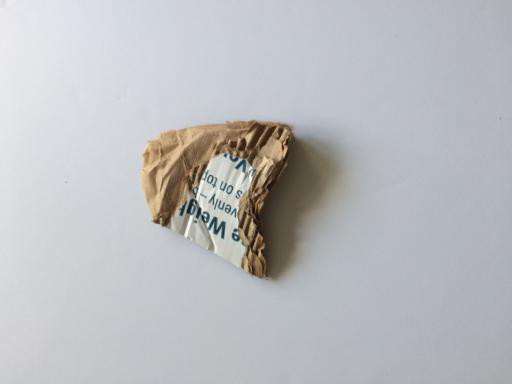

In [23]:
learn.data.test_ds[0][0]

In [24]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [25]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'paper', 'paper', 'plastic', 'metal']
['cardboard', 'paper', 'paper', 'plastic', 'glass']


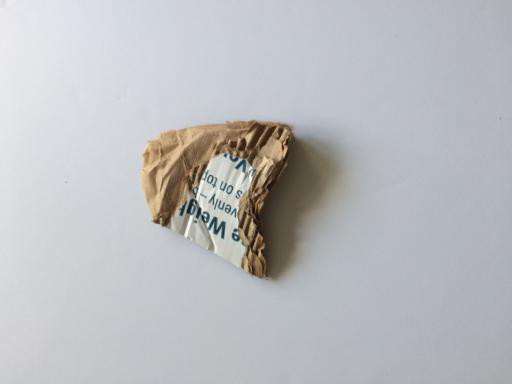

In [26]:
learn.data.test_ds[0][0]

In [27]:
cm = confusion_matrix(y,yhat)
print(cm)

[[  0   3   7  85   6   0]
 [  0 117   7   1   1   0]
 [  0   2  93   1   7   0]
 [  0   0   0 145   4   0]
 [  0   4   0   1 116   0]
 [  0   0   0   9  26   0]]


In [28]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

NameError: name 'waste_types' is not defined

In [29]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [30]:
accuracy = correct/sum(sum(cm))
accuracy

0.7417322834645669

In [ ]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')